# Energy A.I. Hackathon 2024 Workflow - Tigris Mendez

This project was done after the Hackathon event referencing my team's project and the winning teams project.

## Executive Summary



1.   Our task was to predict the Average Pump Difference using features given in a dataset.
2.   Most important features were choosen with XGBoost's important() method
3.   I learned how important domain expertise can be and how a simple model like linear regression can reveal alot about a small dataset.




---

##Goal
Predict Average Pump Difference accurately with the given data



---



##Workflow

1. Import Packages + Dataset
2. Data Preprocessing
3. Feature Selection
4. Data Imputation
5. Linear Regression
6. Uncertainty Model



#Import Packages

In [ ]:
!pip install scikit-learn
!pip install scikit-learn xgboost

In [ ]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

##Read-in Hackathon Dataset

In [ ]:
df = pd.read_csv('/content/HackathonData2024.csv')



---



# Data Preprocessing

**Drop "Area" feature**

Right off the bat. The "Area" feature adds too much complexity with it's various locaitons. This decreases the accuracy. So, we will remove the feature.

In [ ]:
df = df.drop(columns='Area')

**One Hot Encoding**

*Because this data has categorical and numerical data types, we will one-hot encode the data to make them one-hot vectors. This will make all of the data numerical.*




In [ ]:
categorical_columns = ["Fluid System", "Development Strategy", "CODEV_POSITION", "CODEV_FORMATION_POSITION"]

In [ ]:
one_hot_df = pd.concat([df] + [pd.get_dummies(df[col], drop_first = True) for col in categorical_columns], axis=1).drop(columns=categorical_columns)

####'BOUND_CODE' :

The Hackathon organizers gave us a description of the feature named 'BOUND_CODE' which desibes the area plot around a well and whether a well exist in that area or not. Because of this unique data type, it was important to maintain the information present by one-hot encoding converting each BOUND into a seperate section variable.

In [ ]:
# Bound code zone:
#
#  +---+---+---+
#  | 1 | 2 | 3 |
#  +---+---+---+
#  | 4 |   | 5 |
#  +---+---+---+
#  | 6 | 7 | 8 |
#  +---+---+---+
#
#  Example BOUND_CODE : 11100000

**Now we do not need the BOUND_CODE column as this feature is redundant**


In [ ]:
one_hot_df = one_hot_df.drop(columns=["BOUND_CODE"])

**Setting starting features to variable**

In [ ]:
starting_features = one_hot_df.drop(columns=["Avg Pump Difference", "Well ID"])
y = one_hot_df["Avg Pump Difference"]



---



#Data Imputation

##Data Incompleteness
Our data has some missing values, we want to know how much.

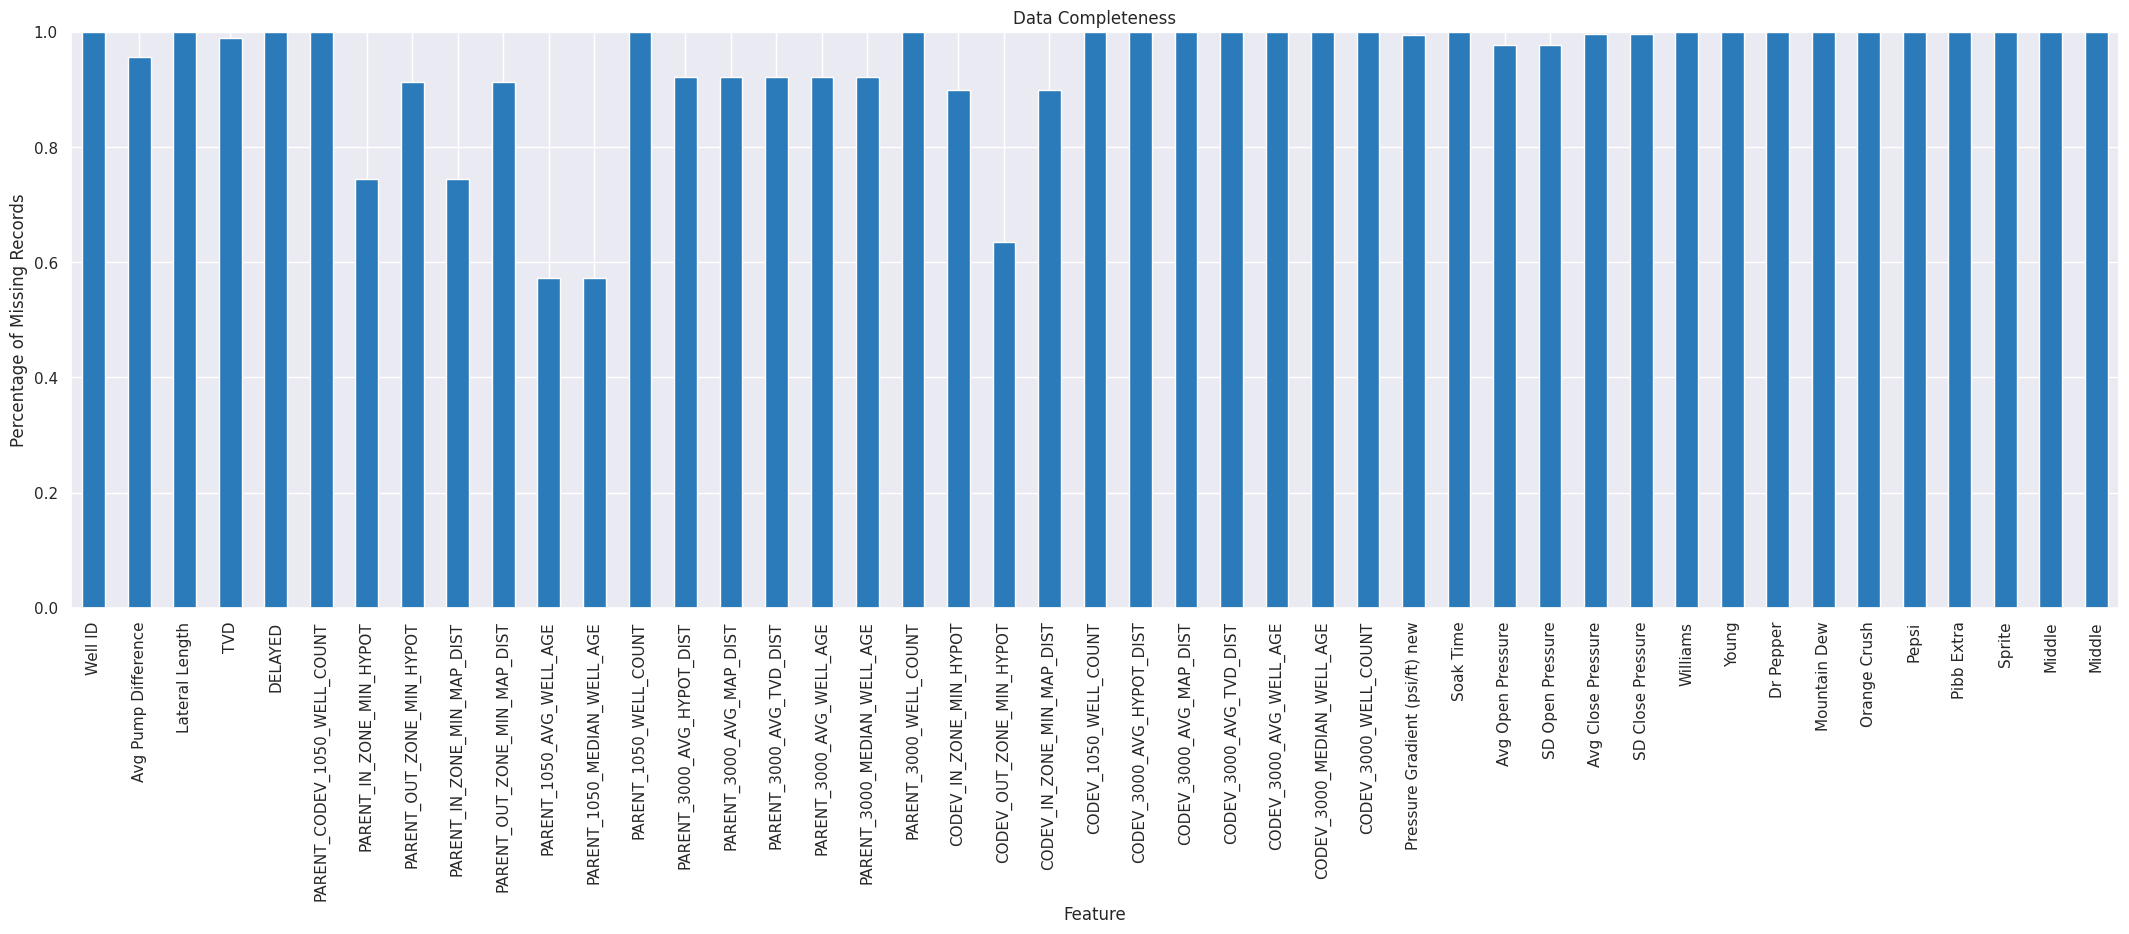

In [ ]:
df_completeness = 1 - one_hot_df.isnull().sum() / len(one_hot_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()

###Should we remove the data incomplete features?
> Removing features could potentially remove valuable information during analysis, so we decided to perform EDA on the Five variables:


*   CODEV_OUT_ZONE_MIN_HYPOT
*   PARENT_1050_MEDIAN_WELL_AGE
*   PARENT_1050_AVG_WELL_AGE
*   PARENT_IN_ZONE_MIN_MAP_DIST
*   PARENT_IN_ZONE_MIN_HYPOT

#### Checking Correlation of select features

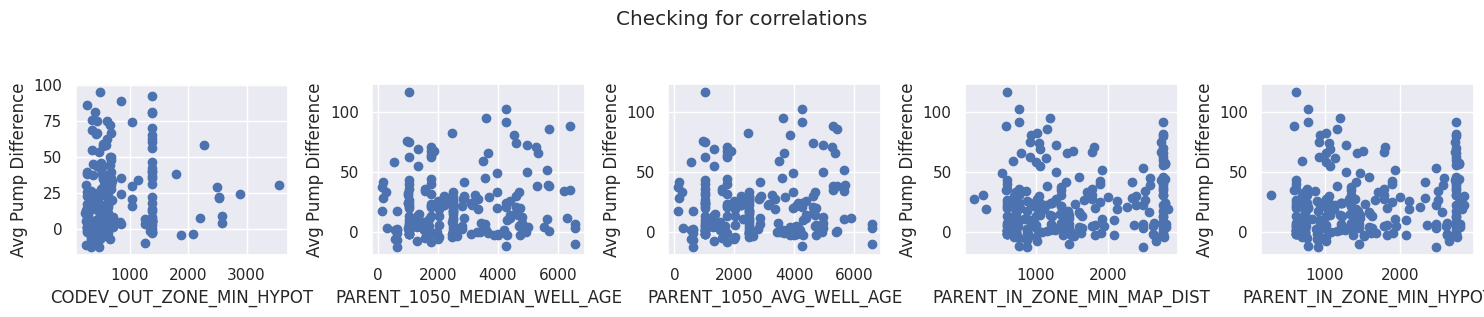

Correlation between CODEV_OUT_ZONE_MIN_HYPOT and Avg Pump Difference: 0.09
Correlation between PARENT_1050_MEDIAN_WELL_AGE and Avg Pump Difference: 0.11
Correlation between PARENT_1050_AVG_WELL_AGE and Avg Pump Difference: 0.08
Correlation between PARENT_IN_ZONE_MIN_MAP_DIST and Avg Pump Difference: 0.09
Correlation between PARENT_IN_ZONE_MIN_HYPOT and Avg Pump Difference: 0.10


In [ ]:
# Variables
variables = ['CODEV_OUT_ZONE_MIN_HYPOT', 'PARENT_1050_MEDIAN_WELL_AGE',
             'PARENT_1050_AVG_WELL_AGE', 'PARENT_IN_ZONE_MIN_MAP_DIST',
             'PARENT_IN_ZONE_MIN_HYPOT']

# Create a figure and subplots
fig, axs = plt.subplots(1, len(variables), figsize=(15, 3), sharey=False)

# Loop through variables and create subplots
for i, variable in enumerate(variables):
    axs[i].scatter(one_hot_df[variable], one_hot_df['Avg Pump Difference'])
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Avg Pump Difference')

# Add a common title to the entire figure
fig.suptitle('Checking for correlations', y=1.05)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()

#______________________________________________________________________________________________

# Calculate and print correlations after handling missing values
for i, variable in enumerate(variables):
    # Drop rows with NaN values for the selected variables
    valid_data = one_hot_df[[variable, 'Avg Pump Difference']].dropna()

    # Calculate and print correlations
    correlation = np.corrcoef(valid_data[variable], valid_data['Avg Pump Difference'])[0, 1]
    print(f'Correlation between {variable} and Avg Pump Difference: {correlation:.2f}')

Due to these features not having any immedeately obvious correlations to the response variable. We will omit them.

##**Data Completeness Post-Omit**

In [ ]:
new_df = one_hot_df.drop(columns=variables)

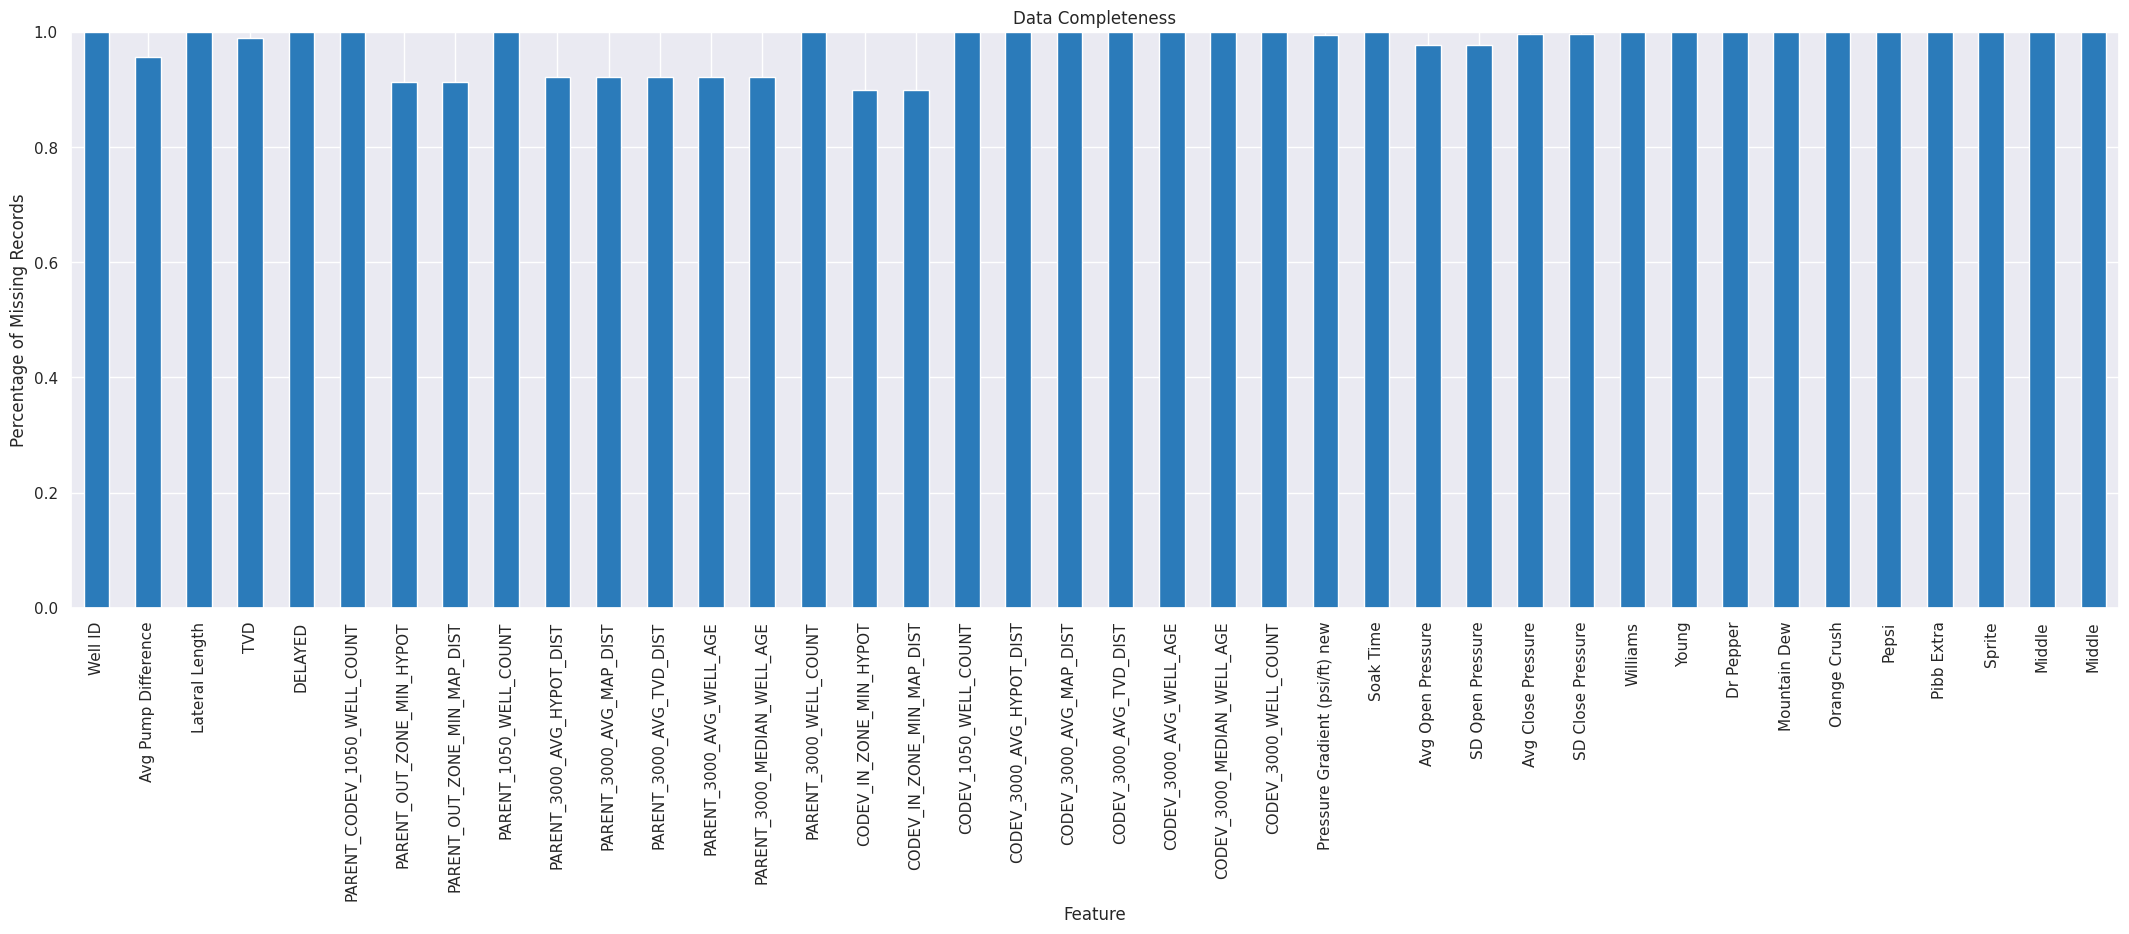

In [ ]:
df_completeness = 1 - new_df.isnull().sum() / len(new_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()


##KNN Data Imputation

I will be using the ***K-Nearest Neighborhood*** method to perform data imputation



In [ ]:
Before_imputation = starting_features
imputer = KNNImputer(n_neighbors=2)
After_imputation = imputer.fit_transform(Before_imputation)
imputated_df = pd.DataFrame(After_imputation, columns=starting_features.columns)

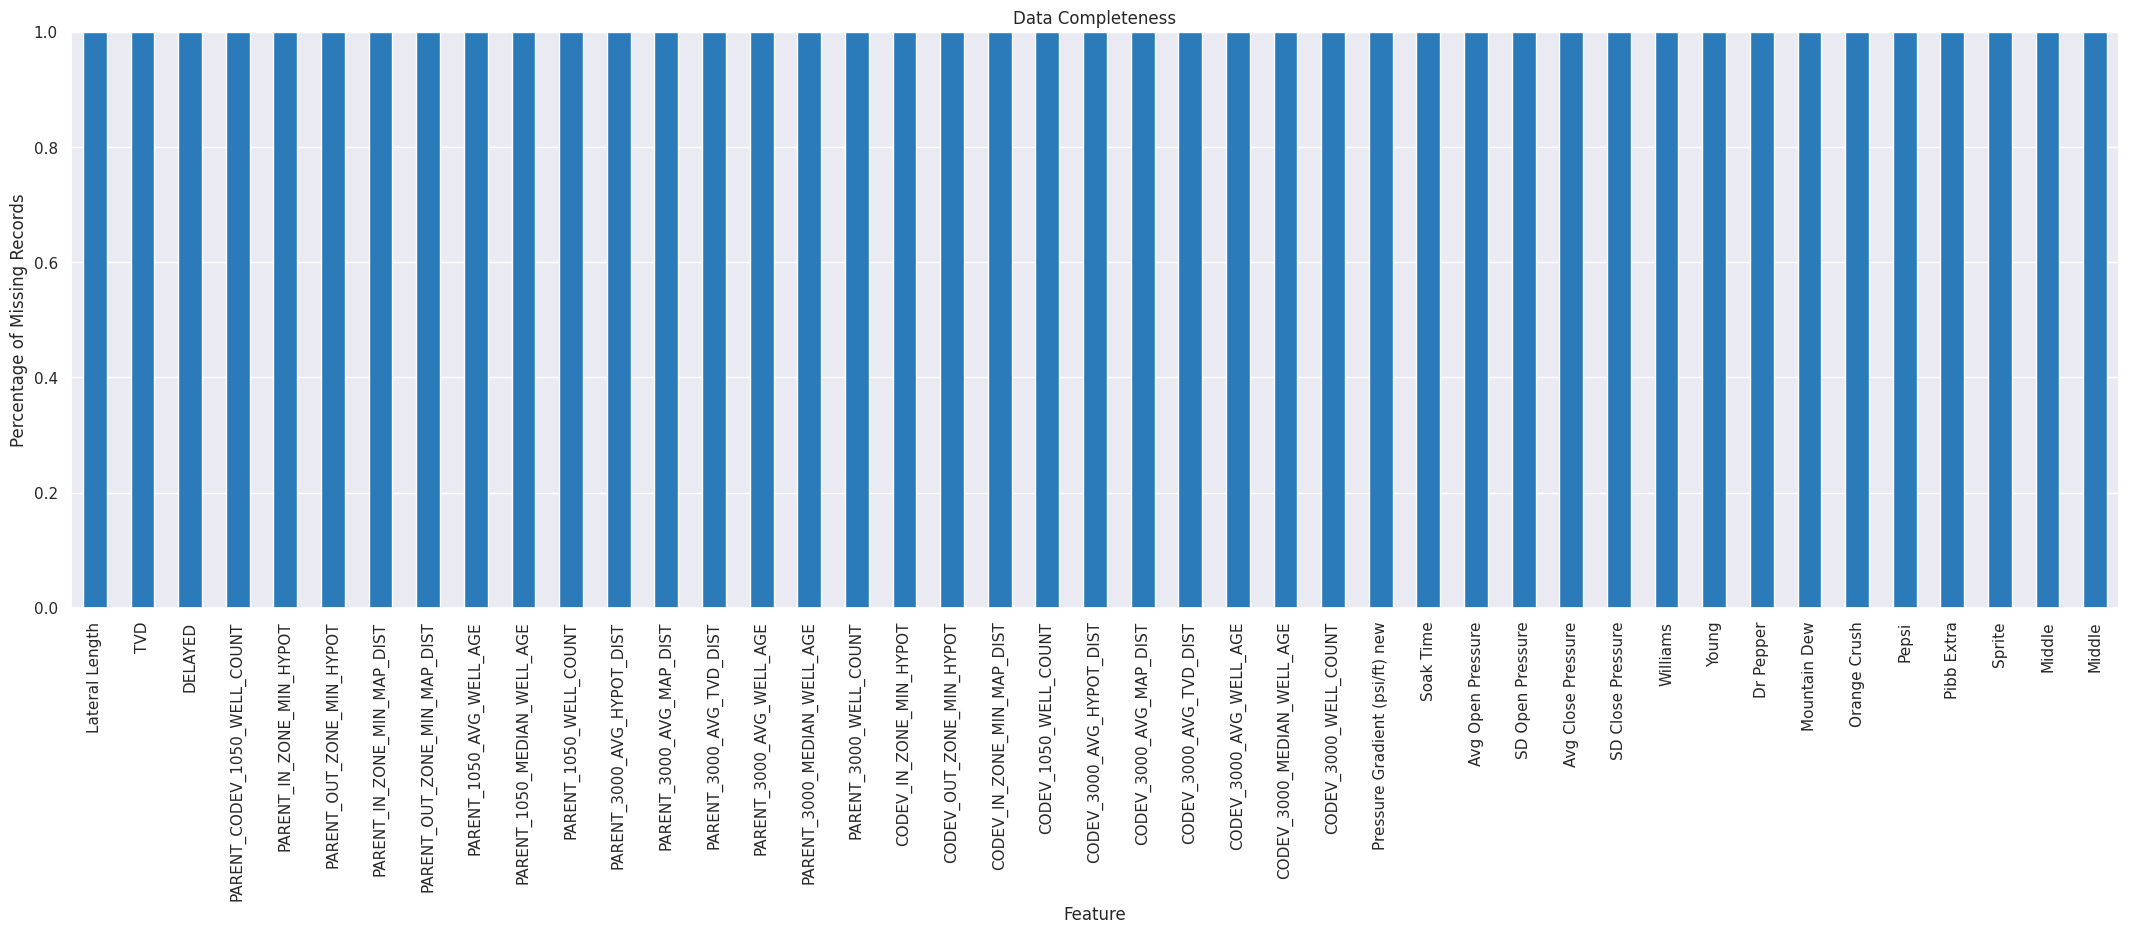

In [ ]:
df_completeness_new = 1 - imputated_df.isnull().sum() / len(imputated_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness_new.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()




---



# Feature Selection

## Collinearity heatmap
A collinearity heatmap informs us which independent variables move in relation to one another. For our numerical values, it is imperitive that we perform a collinearity. Yet, because we one-hot encoded our cateogrical data, we don't need to worry about it.

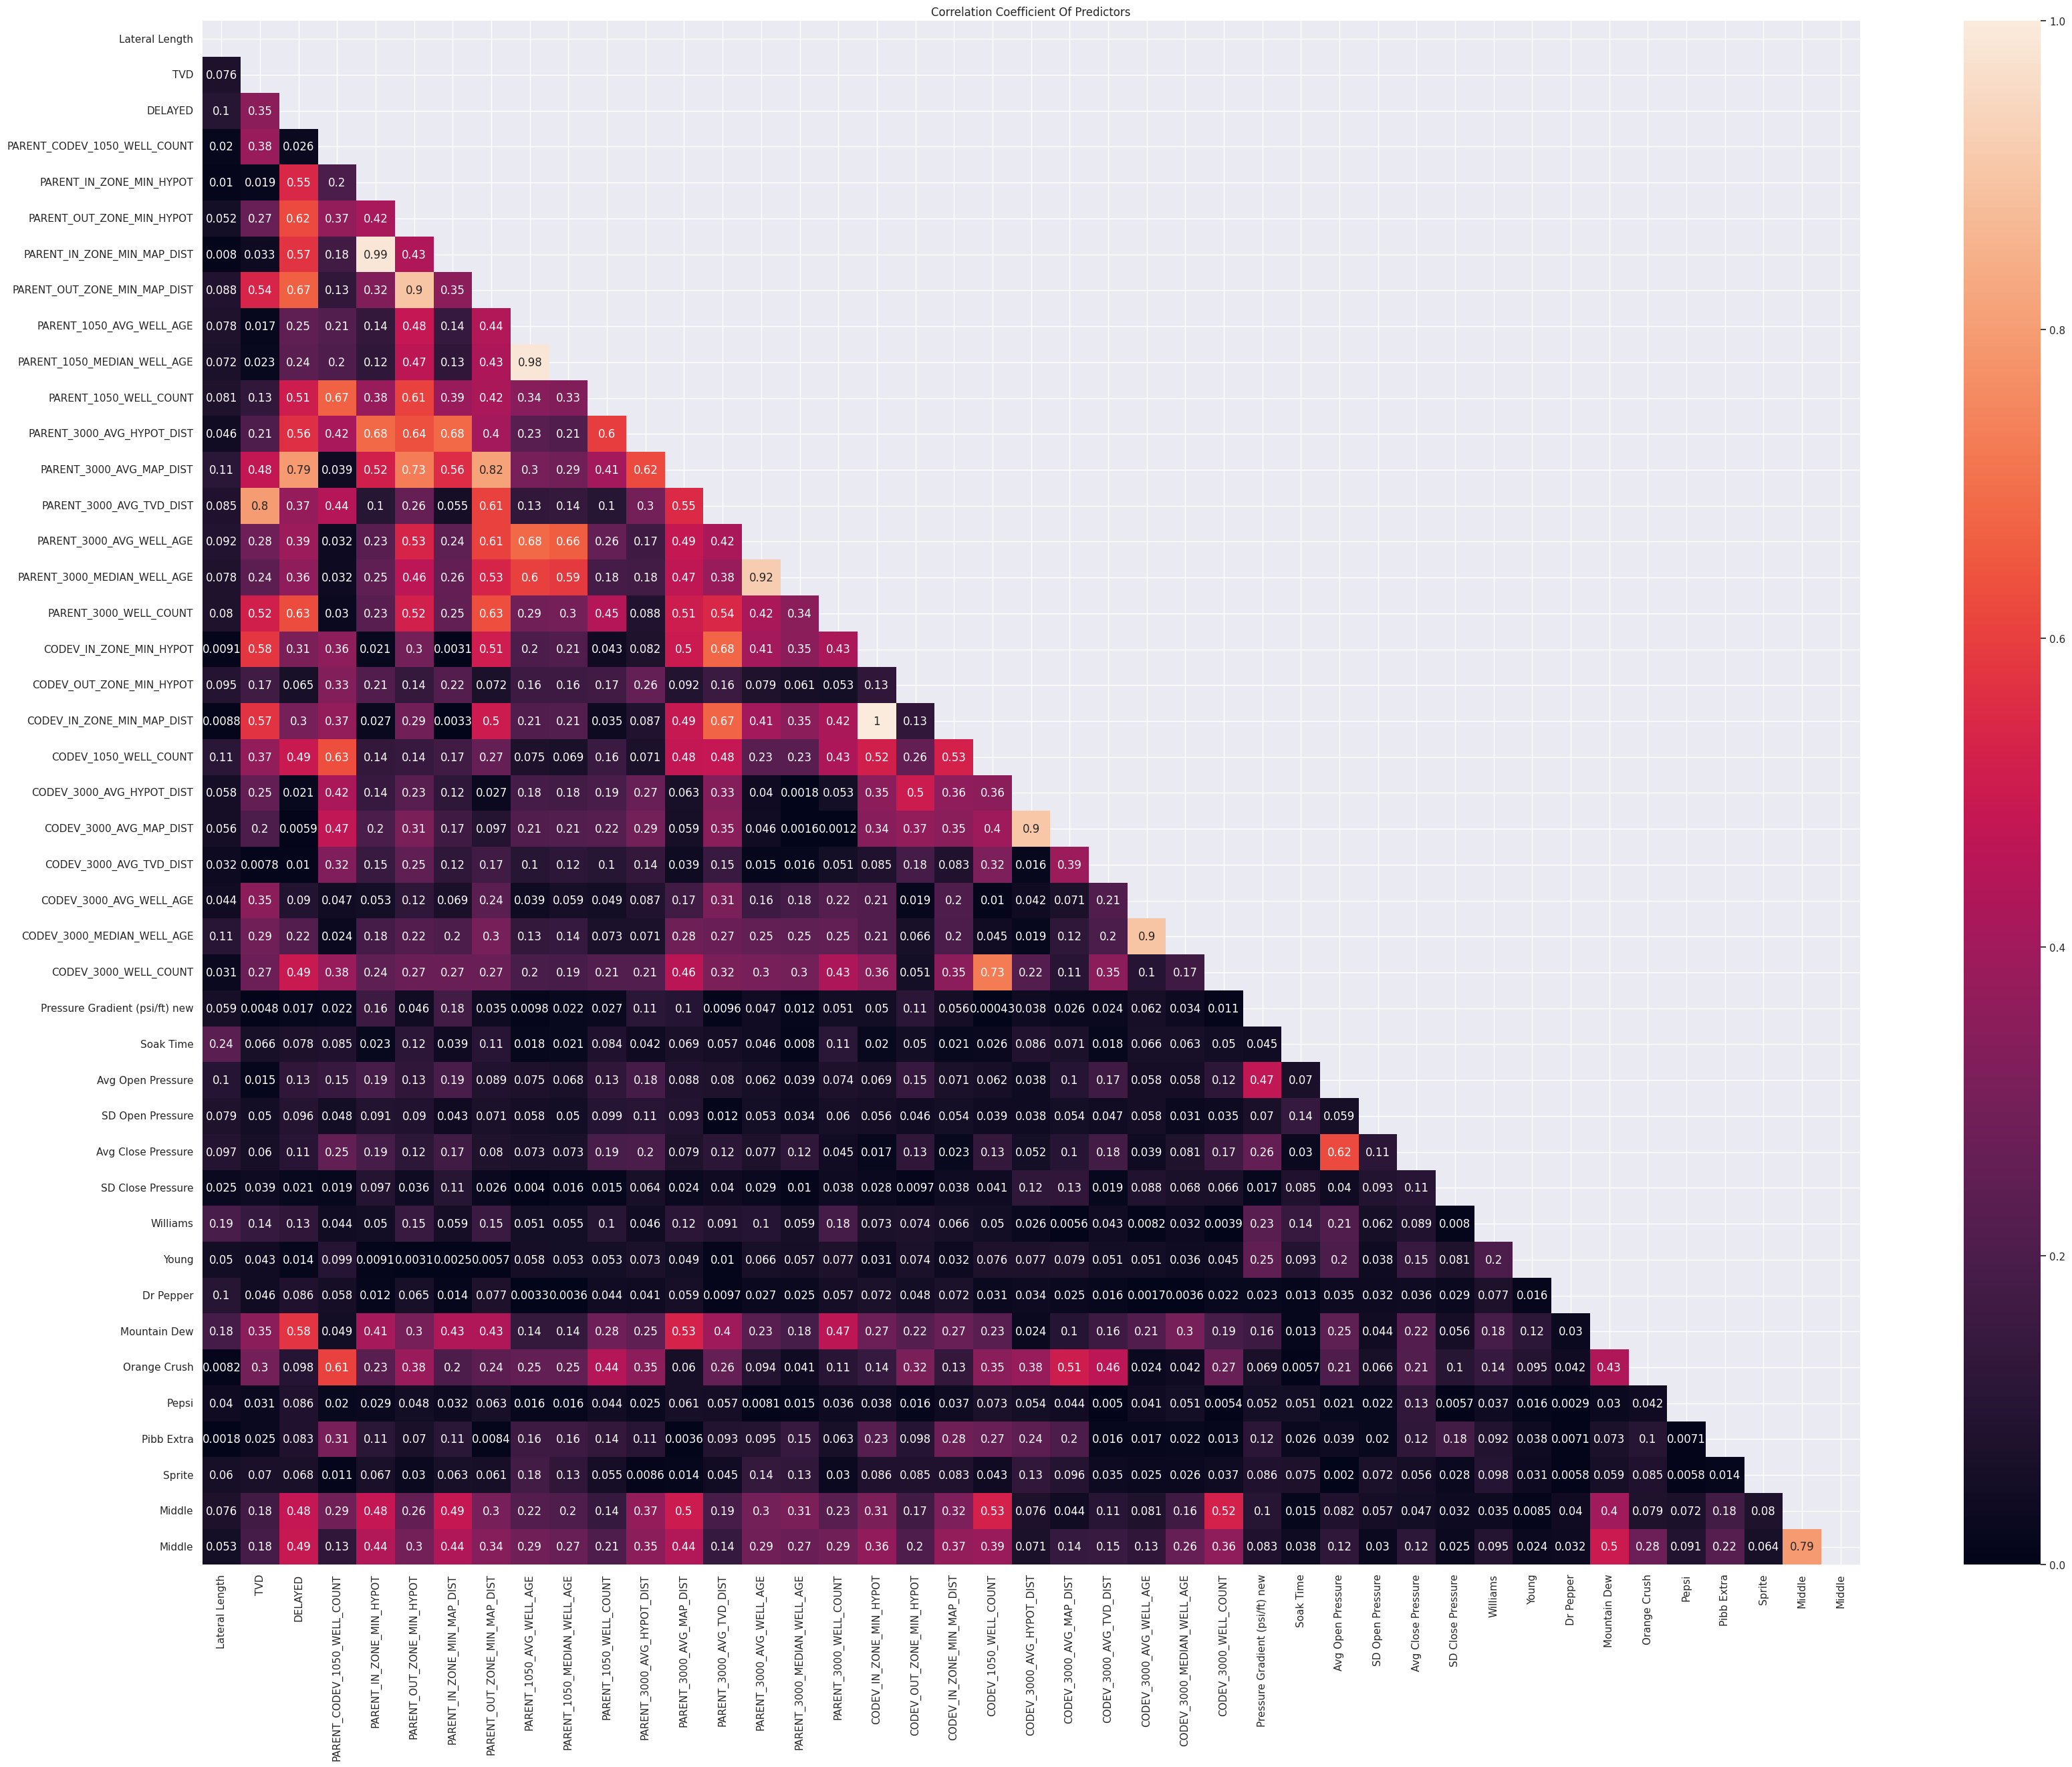

In [ ]:
plt.figure(figsize=(40,30))


# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(imputated_df.corr(), dtype=bool))

# generate
sns.heatmap(abs(imputated_df.corr()), annot=True, mask=mask, vmin=0, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Removed because of colinear redundancy:


> PARENT_IN_ZONE_MIN_MAP_DIST


> PARENT_3000_MEDIAN_WELL_AGE


> CODEV_IN_ZONE_MIN_MAP_DIST


> CODEV_3000_AVG_MAP_DIST


> CODEV_3000_MEDIAN_WELL_AGE


> PARENT_OUT_ZONE_MIN_MAP_DIST


> PARENT_1050_MEDIAN_WELL_AGE





















In [ ]:
removed = [
  'Middle',
  'PARENT_IN_ZONE_MIN_MAP_DIST',
  'PARENT_3000_MEDIAN_WELL_AGE',
  'CODEV_IN_ZONE_MIN_MAP_DIST',
  'CODEV_3000_AVG_MAP_DIST',
  'CODEV_3000_MEDIAN_WELL_AGE',
  'PARENT_OUT_ZONE_MIN_MAP_DIST',
  'PARENT_1050_MEDIAN_WELL_AGE'
]

imputated_df = imputated_df.drop(columns=removed)

## Correlation Heatmap

Checking for any complete correlations to check for depedent behavior in our features

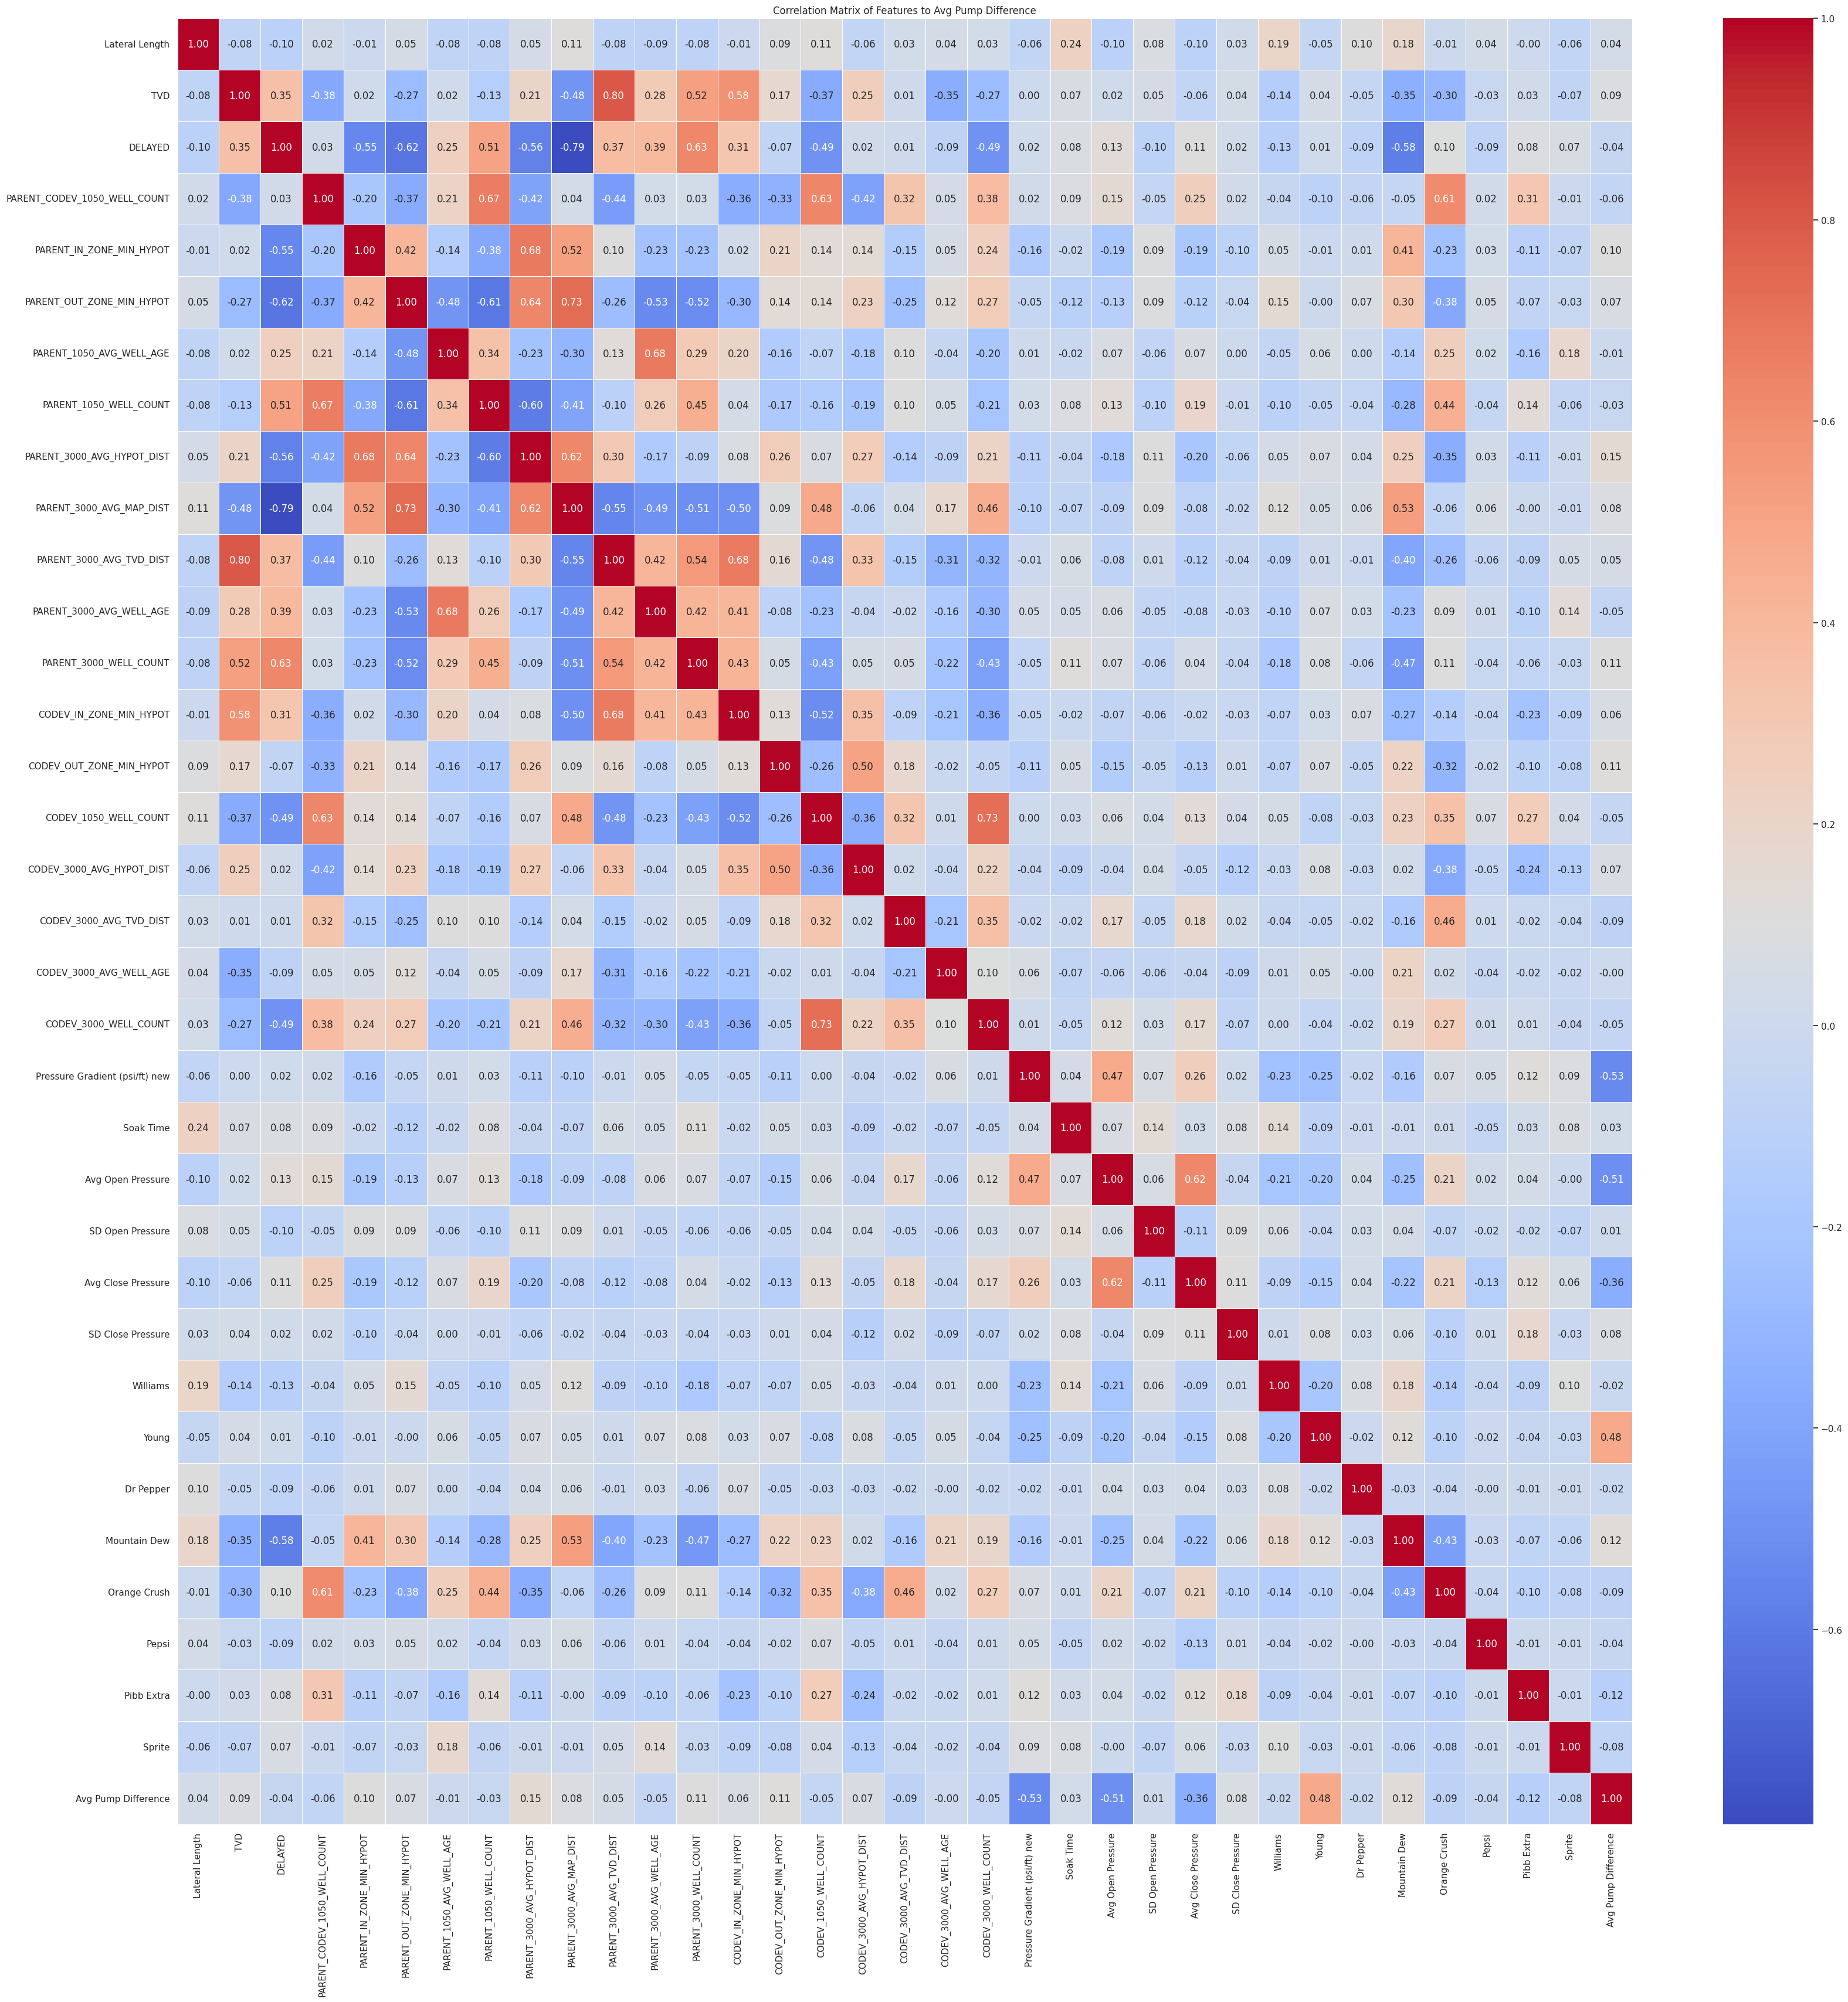

In [ ]:
imputated_df = pd.concat([imputated_df, y], axis=1)

response_variable = 'Avg Pump Difference'  # Replace 'target_column' with the actual name of your response variable
correlation_matrix = imputated_df.corr()

# Create a matrix of scatterplot's correlation results
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title(f'Correlation Matrix of Features to {response_variable}')
plt.show()



##Removing rows missing data of our target variable
We do not want to impute the target variable because this is our 'answer'

**Percentage of rows which are missing target variable**

In [ ]:
missing_percentage = imputated_df['Avg Pump Difference'].isnull().mean()*100
print(missing_percentage, '%')

4.310344827586207 %


**Removed rows with missing target variable values**

In [ ]:
imputated_df = imputated_df.dropna(subset=['Avg Pump Difference'])

missing_pump = one_hot_df['Avg Pump Difference'].isnull()



---



#Linear Regression ( XGBoost Regression + Feature Importance)

*Select Variables*

In [ ]:
X = imputated_df.drop('Avg Pump Difference', axis = 1)
y = imputated_df['Avg Pump Difference']

*Split train and test datasets*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

((249, 34), (84, 34))

*Model*

In [ ]:
model = xgb.XGBRegressor()  # You can customize XGBoost parameters here

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Checking Feature Importance

*** ChatGPT Assisted ***

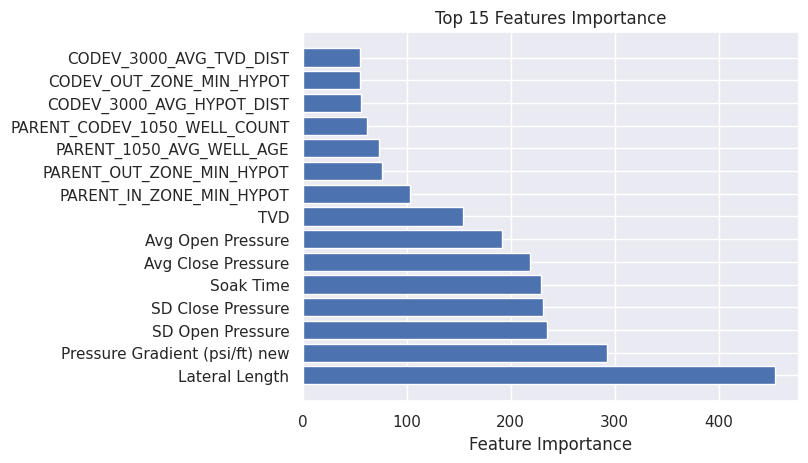

In [ ]:
xgb_regressor = model

booster = xgb_regressor.get_booster()

# Get feature importance scores
importance = booster.get_score(importance_type='weight')

# Sort features by importance and get the top 15
top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:15]

# Extract feature names and importance values
top_feature_names = [feature[0] for feature in top_features]
top_feature_importance = [feature[1] for feature in top_features]

# Plot
plt.barh(range(15), top_feature_importance, align='center')
plt.yticks(range(15), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 15 Features Importance')
plt.show()


###We will continue to *select* features down to the 8 most important

In [ ]:
removed_2 = [
    'PARENT_OUT_ZONE_MIN_HYPOT',
    'PARENT_IN_ZONE_MIN_HYPOT',
    'Avg Close Pressure',
    'Avg Open Pressure',
    'Pressure Gradient (psi/ft) new',
    'Lateral Length',
    'TVD',
    'Avg Pump Difference'
]

imputated_df_2 = imputated_df.loc[:, imputated_df.columns.isin(removed_2)]

####Checking for correlations

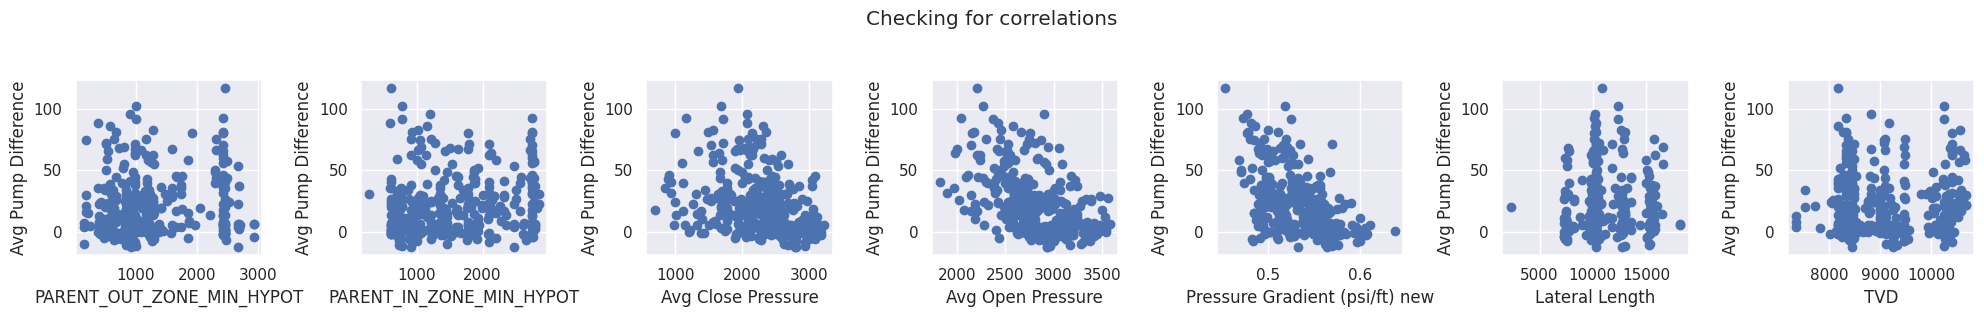

Correlation between PARENT_OUT_ZONE_MIN_HYPOT and Avg Pump Difference: 0.07
Correlation between PARENT_IN_ZONE_MIN_HYPOT and Avg Pump Difference: 0.10
Correlation between Avg Close Pressure and Avg Pump Difference: -0.36
Correlation between Avg Open Pressure and Avg Pump Difference: -0.51
Correlation between Pressure Gradient (psi/ft) new and Avg Pump Difference: -0.53
Correlation between Lateral Length and Avg Pump Difference: 0.04
Correlation between TVD and Avg Pump Difference: 0.09


In [ ]:
variables = [
    'PARENT_OUT_ZONE_MIN_HYPOT',
    'PARENT_IN_ZONE_MIN_HYPOT',
    'Avg Close Pressure',
    'Avg Open Pressure',
    'Pressure Gradient (psi/ft) new',
    'Lateral Length',
    'TVD'
]

# Create a figure and subplots
fig, axs = plt.subplots(1, len(variables), figsize=(20, 3), sharey=False)

# Loop through variables and create subplots
for i, variable in enumerate(variables):
    if variable in imputated_df_2.columns:
        axs[i].scatter(imputated_df_2[variable], imputated_df_2['Avg Pump Difference'])
        axs[i].set_xlabel(variable)
        axs[i].set_ylabel('Avg Pump Difference')
    else:
        print(f"Variable '{variable}' not found in DataFrame")

# Add a common title to the entire figure
fig.suptitle('Checking for correlations', y=1.05)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()

#______________________________________________________________________________________________

# ** Below is ChatGPT assisted **

# Calculate and print correlations after handling missing values
for i, variable in enumerate(variables):
    # Drop rows with NaN values for the selected variables
    valid_data = imputated_df_2[[variable, 'Avg Pump Difference']].dropna()

    # Calculate and print correlations
    correlation = np.corrcoef(valid_data[variable], valid_data['Avg Pump Difference'])[0, 1]
    print(f'Correlation between {variable} and Avg Pump Difference: {correlation:.2f}')

##Training Regression Model

In [ ]:
X = imputated_df_2.drop('Avg Pump Difference', axis = 1)
y = imputated_df_2['Avg Pump Difference']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

((249, 7), (84, 7))

In [ ]:
model = xgb.XGBRegressor()  # You can customize XGBoost parameters here

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##Train Performance

In [ ]:
pred_train = model.predict(X_train)

In [ ]:
print('Training set R^2 score: ', r2_score(y_train, pred_train))

print('Training set Mean Squared error: ',mean_squared_error(y_train, pred_train))

Training set R^2 score:  0.999998797199016
Training set Mean Squared error:  0.000705699947315783


##Test Performance

The R^2 score is: 0.43534993290008217
The mean squared error is: 325.0127389910141


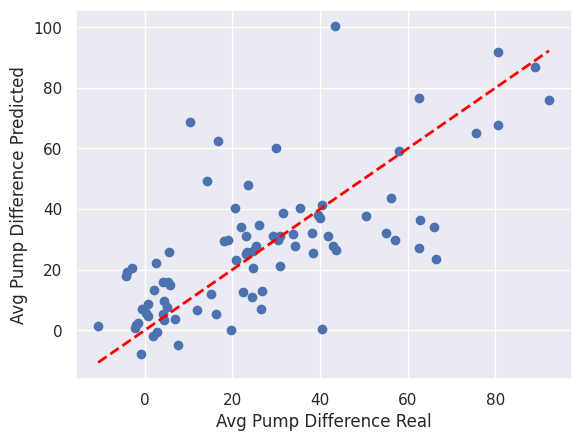

In [ ]:
predictions = model.predict(X_test)

print('The R^2 score is:', r2_score(y_test, predictions))

model.score(X_test, y_test)

print('The mean squared error is:', mean_squared_error(y_test, predictions))

plt.scatter(y_test, predictions)
plt.xlabel("Avg Pump Difference Real")
plt.ylabel("Avg Pump Difference Predicted")

# Add a 45-degree line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='45-degree line')

plt.show()

##Hyperparameter Tuning


In [ ]:
model = xgb.XGBRegressor()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create a scorer for GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error on Test Set:", mse)


Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Mean Squared Error on Test Set: 260.886523853189


###Best Model Tunning

***Run model post hypertuning***

In [ ]:
# Create an XGBoost regressor with the best parameters
best_model = xgb.XGBRegressor(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=0.8
)

# Train the model on your training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 260.886523853189


The R^2 score is: 0.5467574789330326
The mean squared error is: 260.886523853189


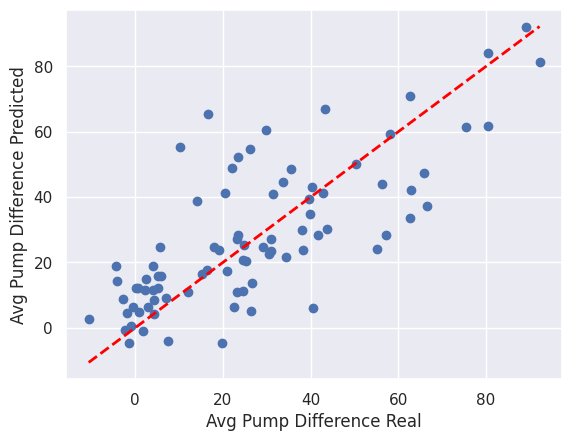

In [ ]:
# predictions = best_model.predict(X_test)

print('The R^2 score is:', r2_score(y_test, predictions))

best_model.score(X_test, y_test)

print('The mean squared error is:', mean_squared_error(y_test, predictions))

plt.scatter(y_test, predictions)
plt.xlabel("Avg Pump Difference Real")
plt.ylabel("Avg Pump Difference Predicted")

# Add a 45-degree line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='45-degree line')

plt.show()



---



#Uncertainty Model

In [ ]:
from scipy.stats import norm

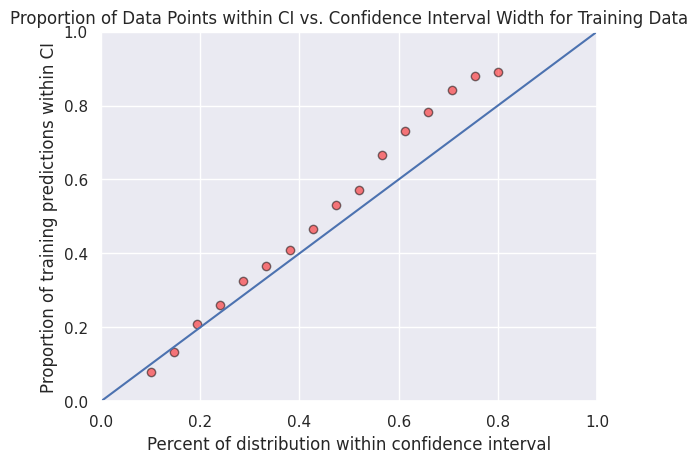

In [ ]:
y_train_pred = best_model.predict(X_train)
y_train_pred = np.asarray(y_train_pred).ravel()
y_train = np.asarray(y_train).ravel()

apd_mean = y_train.mean()
apd_std = y_train.std()
xi = np.zeros(16)
norm_total = 0

pperc = np.linspace(0.1, 0.8, 16)

for i in range(16):
    alpha = 1 - pperc[i]  # Convert percentile to alpha
    alpha /= 2  # Divide alpha by 2 for two-tailed confidence interval

    upper_CI = apd_mean + apd_std * norm.ppf(1-alpha)
    lower_CI = apd_mean - apd_std * norm.ppf(1-alpha)

    for j in range(0, len(y_train_pred)):
      if y_train_pred[j] < upper_CI and y_train_pred[j] > lower_CI:
        xi[i]=xi[i]+1
    xi[i] = xi[i]/(len(y_train))

    a = 1 if xi[i] > pperc[i] else 0
    norm_total += (((3 * a - 2)) + ((xi[i] - pperc[i]))) * 1 / (len(pperc) + 1)

plt.axline((0, 0), (1, 1))
plt.xlabel("Percent of distribution within confidence interval")
plt.ylabel("Proportion of training predictions within CI")
plt.title("Proportion of Data Points within CI vs. Confidence Interval Width for Training Data")

plt.xlim(0,1); plt.ylim(0,1)
plt.scatter(pperc, xi,c='red',alpha=0.5,edgecolor='black')
plt.show()
